## **IEEE-CIS Fraud Detection**<br>
Predicting the probability that an online transaction is fraudulent from Vesta's real-world e-commerce transactions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, plot_roc_curve, precision_score
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

In [2]:
#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#importing the kaggle dataset
#import os
#os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Colab Notebooks/Kaggle/IEEE-CIS Fraud Detection'

#changing to the working directory
#%cd /content/drive/MyDrive/Colab Notebooks/Kaggle/IEEE-CIS Fraud Detection

#Kaggle API command for the dataset
#!kaggle competitions download -c ieee-fraud-detection

In [4]:
#unzipping the zip files and deleting the zip files
#!unzip \*.zip  && rm *.zip

In [5]:
#specifying file paths
test_identity = '/content/drive/MyDrive/Colab Notebooks/Kaggle/IEEE-CIS Fraud Detection/test_identity.csv'
test_transaction = '/content/drive/MyDrive/Colab Notebooks/Kaggle/IEEE-CIS Fraud Detection/test_transaction.csv'
train_identity = '/content/drive/MyDrive/Colab Notebooks/Kaggle/IEEE-CIS Fraud Detection/train_identity.csv'
train_transaction = '/content/drive/MyDrive/Colab Notebooks/Kaggle/IEEE-CIS Fraud Detection/train_transaction.csv'

**1) Loading and Checking the Data**

In [6]:
trainid = pd.read_csv(train_identity, low_memory=False)
traintran = pd.read_csv(train_transaction, low_memory=False)
testid = pd.read_csv(test_identity, low_memory=False)
testtran = pd.read_csv(test_transaction, low_memory=False)

In [7]:
trainid.sample(5)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
26879,3059819,-10.0,93893.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,225.0,NaN,427.0,325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 63.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
128235,3505585,-5.0,89369.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,64.0,-360.0,Found,Found,166.0,NaN,399.0,333.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_12_6,safari generic,24.0,2560x1600,match_status:2,T,F,T,F,desktop,MacOS
2873,2999553,-5.0,163836.0,0.0,0.0,3.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,49.0,-360.0,Found,Found,166.0,13.0,548.0,611.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 7.0,samsung browser 6.2,32.0,1920x1080,match_status:2,T,F,T,F,mobile,SAMSUNG SM-G930P Build/NRD90M
60718,3133321,-20.0,140404.0,NaN,NaN,0.0,-30.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,NaN,Unknown,NaN,225.0,13.0,266.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,mobile safari 11.0,NaN,NaN,NaN,F,F,F,T,mobile,NaN
51844,3103136,-5.0,102629.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,542.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.0.3,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,F,mobile,iOS Device


In [8]:
traintran.sample(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
357331,3344331,0,8861740,117.000,W,1342,514.0,150.0,mastercard,224.0,debit,325.0,87.0,2.0,NaN,aol.com,NaN,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,4.0,0.0,12.0,2.0,54.0,54.0,1.0,167.0,1.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,117.000000,194.000000,194.000000,117.0,194.000000,0.0,194.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
285754,3272754,0,7004784,51.000,W,7999,140.0,150.0,visa,226.0,debit,204.0,87.0,10.0,NaN,NaN,NaN,3.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,3.0,1.0,17.0,2.0,213.0,213.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,139.000000,1848.000000,412.000000,29.0,1738.000000,0.0,302.000000,0.0,0.0,0.0,110.0,110.0,110.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
304324,3291324,0,7527585,11.661,C,11201,103.0,185.0,visa,226.0,debit,NaN,NaN,NaN,0.0,gmail.com,gmail.com,3.0,15.0,0.0,2.0,0.0,2.0,2.0,4.0,0.0,3.0,4.0,4.0,10.0,1.0,0.0,NaN,0.0,491.0,0.0,491.0,0.0,0.083333,0.083333,...,0.0,0.0,1.0,1.0,1.0,1.0,23.322201,23.322201,23.322201,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100267,3087267,0,2026234,100.000,R,16659,170.0,150.0,visa,226.0,credit,231.0,87.0,NaN,4.0,yahoo.com,yahoo.com,1.0,1.0,0.0,2.0,0.0,1.0,0.0,3.0,0.0,2.0,1.0,0.0,3.0,1.0,365.0,365.0,262.0,365.0,262.0,365.0,365.0,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38887,3025887,0,949661,35.950,W,10989,360.0,150.0,visa,166.0,debit,191.0,87.0,2.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,10.0,7.0,0.0,0.0,6.0,0.0,3.0,0.0,50.0,6.0,162.0,162.0,2.0,330.0,2.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,298.850006,30.950001,0.0,298.850006,0.0,30.950001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#checck for duplicate records
print('train/test identity records are duplicated:', trainid.duplicated().sum(), testid.duplicated().sum())
print('train/test transaction records are duplicated:', traintran.duplicated().sum(), testtran.duplicated().sum())

train/test identity records are duplicated: 0 0
train/test transaction records are duplicated: 0 0


**2) Exploratory Data Analysis**

In [10]:
#understanding the shape of the data
print('train/test identity shape:', trainid.shape, testid.shape)
print('train/test transaction shape:', traintran.shape, testtran.shape)

train/test identity shape: (144233, 41) (141907, 41)
train/test transaction shape: (590540, 394) (506691, 393)


**2.1) Transaction data**

2.11) What amount of transactions are fraudulent?

In [11]:
# pct of transactions that is fraudulent
print(np.round(traintran[traintran['isFraud']==1]['isFraud'].count()/traintran.shape[0]*100, 3), '% of transactions are fraudulent')

3.499 % of transactions are fraudulent


This results signifies that the data is heavily imbalanced and requires processing before modelling.

In [12]:
# check if fradulent transaction id cross matches to identity dataset
fraudid = traintran[traintran['isFraud']==1]['TransactionID']
print('fraud transaction IDs not in identity table:', fraudid.isin(~trainid['TransactionID']).sum())

fraud transaction IDs not in identity table: 0


2.12) Transaction amount

In [13]:
# first, checking for the min/max transaction amount
print('Transaction amt min max:', traintran['TransactionAmt'].min(), '/', traintran['TransactionAmt'].max())

Transaction amt min max: 0.251 / 31937.391


Given the disparity, logrithmic scale is to be applied to the data plots.

In [14]:
traintran['TransactionAmt'].describe()

count    590540.000000
mean        135.027176
std         239.162522
min           0.251000
25%          43.321000
50%          68.769000
75%         125.000000
max       31937.391000
Name: TransactionAmt, dtype: float64

Text(0.5, 1.0, 'Log Chart of Transaction Amount')

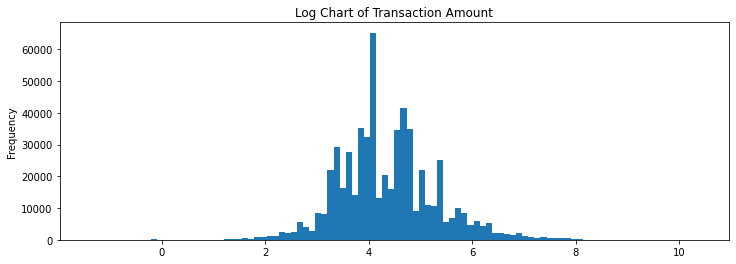

In [15]:
trans_log = traintran['TransactionAmt'].apply(np.log)
trans_log.plot(kind='hist', bins=100, figsize=(12, 4))
plt.title('Log Chart of Transaction Amount')

Text(0.5, 1.0, 'Log Chart of Fraudulent Transaction Amount')

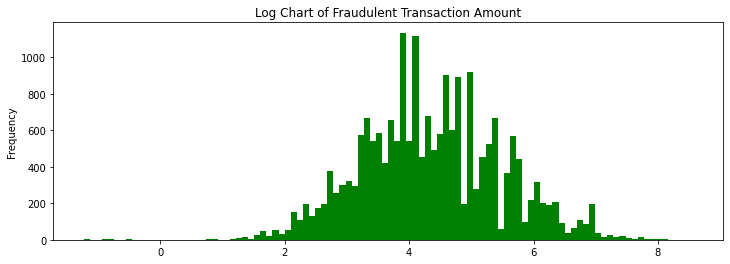

In [16]:
#overlaying transcation amount for fraudulent and normal transactions
flog = traintran.loc[traintran['isFraud']==1]['TransactionAmt'].apply(np.log)
flog.plot(kind='hist', bins=100, figsize=(12, 4), color='green')
plt.title('Log Chart of Fraudulent Transaction Amount')

The fraudulent transactions seem to be having a slightly higher amount than the general trend.

2.13) ProductCD <br>
ProductCD refers to Product Code in each transaction.

Text(0.5, 1.0, 'Purchased Product (by Product Code')

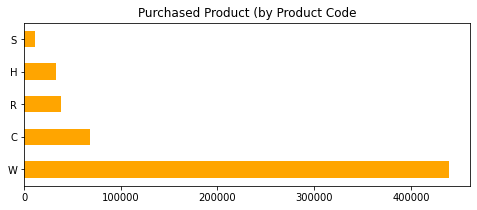

In [17]:
traintran['ProductCD'].value_counts().plot(kind='barh', figsize=(8, 3), color='orange')
plt.title('Purchased Product (by Product Code')

Text(0.5, 1.0, 'Avg Purchased Transaction Amt (by Product Code')

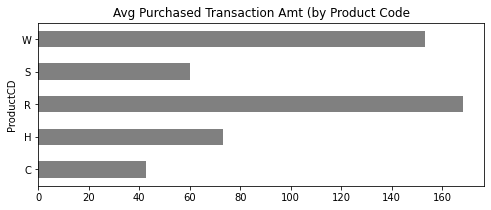

In [18]:
# avg transaction price by product code
traintran.groupby('ProductCD')['TransactionAmt'].mean().plot(kind='barh', figsize=(8, 3), color='grey')
plt.title('Avg Purchased Transaction Amt (by Product Code')

Text(0.5, 1.0, 'Avg Fraudulent Transactions Amt (by Product Code')

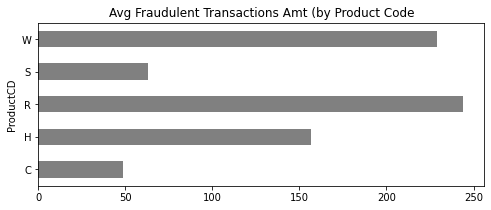

In [19]:
# Product breakdown by fraudulent activities
f_tran = traintran.loc[traintran['isFraud']==1]
f_tran.groupby('ProductCD')['TransactionAmt'].mean().plot(kind='barh', figsize=(8, 3), color='grey')
plt.title('Avg Fraudulent Transactions Amt (by Product Code')

In [20]:
# Products with most fradulent transactions
f_tran['ProductCD'].value_counts()

W    8969
C    8008
H    1574
R    1426
S     686
Name: ProductCD, dtype: int64

Though seeing the average transaction amount by product between normal vs fraudulent transcations, it is quite apparent fraudulent transactions has higher average transaction value, while on product type, Product C generally has much fewer transcation, but it is occuring in a high frequency on fraudulent transactions. 

2.14) Credit Cards/ Fraud Cases <br>
Despite indications that these are all categorical values, only columns card 4 and card 6 appears to be an object, rest a numeric.

In [21]:
datalist = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']
traintran[datalist].dtypes

card1      int64
card2    float64
card3    float64
card4     object
card5    float64
card6     object
dtype: object

understanding data inside card4 and card6 column

Text(0.5, 1.0, 'Breakdown of payment types - Normal Transactions')

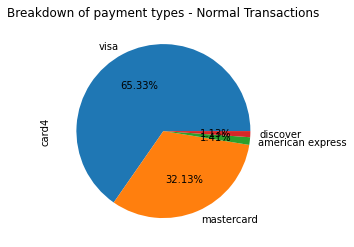

In [22]:
traintran['card4'].value_counts().plot(kind='pie', autopct='%1.2f%%')
plt.title('Breakdown of payment types - Normal Transactions')

Text(0.5, 1.0, 'Breakdown of payment types - Fraudulent Transactions')

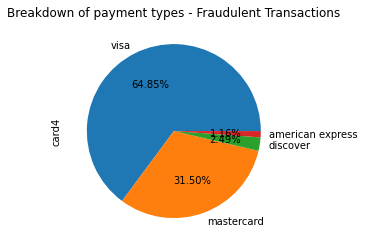

In [23]:
f_tran['card4'].value_counts().plot(kind='pie', autopct='%1.2f%%')
plt.title('Breakdown of payment types - Fraudulent Transactions')

In [24]:
traintran['card6'].value_counts()

debit              439938
credit             148986
debit or credit        30
charge card            15
Name: card6, dtype: int64

In [25]:
f_tran['card6'].value_counts()

debit     10674
credit     9950
Name: card6, dtype: int64

2.15) Other Miscellaneous Features

*   C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
*   D1-D15: timedelta, such as days between previous transaction, etc.
*   Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.








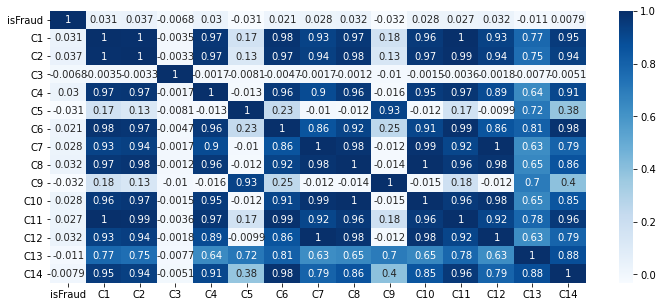

In [26]:
#C1-C14
C_cols = traintran.filter(regex='^C|isFraud',axis=1)
plt.subplots(figsize=(12, 5))
sns.heatmap(C_cols.corr(), annot=True, cmap='Blues')

In [27]:
#D1-D15
D_cols = traintran.filter(regex='^D|isFraud',axis=1)
D_cols.head()

,isFraud,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
0,0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0
1,0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2,0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0
3,0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0
4,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


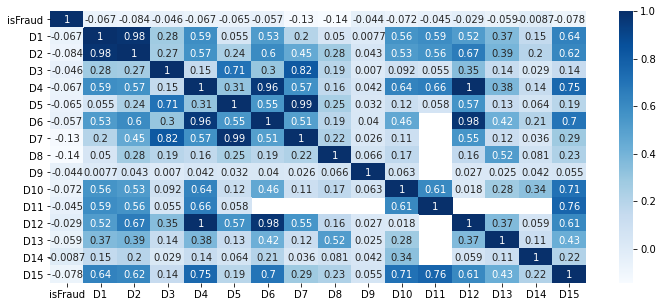

In [28]:
plt.subplots(figsize=(12, 5))
sns.heatmap(D_cols.corr(), annot=True, cmap='Blues')

In [72]:
#Vesta features
V_cols = traintran.filter(regex='^V',axis=1)

#show pct of null values in each column
V_null = {}

#for loop to show % missing
V_cols_name = V_cols.columns
for name in V_cols_name:
  pct = V_cols[name].isnull().sum()/V_cols.shape[0]*100
  V_null[name] = pct

V_null = pd.DataFrame(V_null.items(), columns=['feature', '% missing'])

In [81]:
print('Out of 339 Vesta features, proportion with at least half of the data is null')
V_null[V_null['% missing'] > 50].count()

Out of 339 Vesta features, proportion with at least half of the data is null


feature      159
% missing    159
dtype: int64

In [82]:
print(traintran.shape)
traintran.isnull().sum().to_frame().T

(590540, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,0,0,0,0,0,0,8933,1565,1577,4259,1571,65706,65706,352271,552913,94456,453249,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1269,280797,262878,168922,309841,517353,551623,515614,515614,...,1269,1269,12,12,12,12,12,12,12,12,12,12,12,1269,1269,1269,12,12,12,12,12,12,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189


**2.2) Identity data**